In [1]:
# license: GPL v3
import json
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import openpyxl

In [2]:
# characters of each type to sample
teamSizes = {
    "townsfolk" : 13,
    "outsider" : 4,
    "minion" : 4,
    "demon" : 4,
}

In [3]:
# restrictions of the form "if script contins key it must also contain value"
hardRestrictions = {
    "huntsman" : "damsel",
    "choirboy" : "king",    
}

In [4]:
# a version of Standard "Amy" Order
def SAO(_s):
    s = _s.lower()
    if s.startswith("you start"):
        return 1
    if s.startswith("each night*"):
        return 3
    if s.startswith("each night"):
        return 2
    if s.startswith("each day"):
        return 4
    if s.startswith("once per game, at night*"):
        return 6
    if s.startswith("once per game, at night"):
        return 5
    if s.startswith("once per game, during the day"):
        return 7
    if s.startswith("once per game"):
        return 8
    if s.startswith("on your 1st day"):
        return 10
    if s.startswith("on your 1st night"):
        return 9
    if s.startswith("if you"):
        return 11
    if s.startswith("if"):
        return 12
    if s.startswith("you"):
        return 13
    return 14

In [5]:
def SanitizeName(s):
    s = s.lower()
    s = s.replace(' ', '_')
    if s == "mephit":
        s = "mezepheles"
    return s

In [6]:
# record the team and SAO class of each role, etc
teams = {}
roleSAOs = {}
roleTeams = {}

roles = []
rolesInv = {}

for team in teamSizes.keys():
    teams[team] = []
    
with open("roles.json") as j:
    jsonRoles = json.load(j)
    jsonRoles = sorted(jsonRoles, key=lambda x: SAO(x["ability"]))
    jsonRoles = sorted(jsonRoles, key=lambda x: x["team"], reverse=True)
    for role in jsonRoles:
        if role["team"] not in teams:
            continue
        if role["id"] == "mephit":
            continue # included with both names in roles.json
        roleId = SanitizeName(role["name"])
        teams[role["team"]].append(roleId)
        roleSAOs[roleId] = SAO(role["ability"])
        roles.append(roleId)
        rolesInv[roleId] = len(roles)-1
        roleTeams[roleId] = role["team"]

In [7]:
# set role adjacency matrix
# set SAO distribution (for townsfolk)
roleAdjacency = np.zeros((len(roles), len(roles)))
amyDist = {}

for i in sorted(roleSAOs.values()):
    amyDist[i] = 0

scripts = glob.glob(os.path.join("./","data_scripts/")+"*.json")
for script in scripts:
    with open(script) as j:
        try:
            jsonScript = json.load(j)
        except:
            pass
        scriptRoles = []
        for role in jsonScript:
            roleId = SanitizeName(role["id"])
            if roleId not in roles:
                continue
            scriptRoles.append(roleId)
            assert(roleId in roles)
            if roleId in teams["townsfolk"]:
                amyDist[roleSAOs[roleId]] += 1
        for role1 in scriptRoles:
            for role2 in scriptRoles:
                if role1 == role2:
                    continue
                roleAdjacency[rolesInv[role1],rolesInv[role2]] += 1

<Figure size 432x288 with 0 Axes>

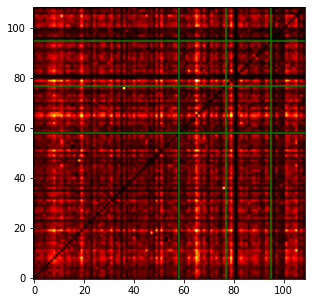

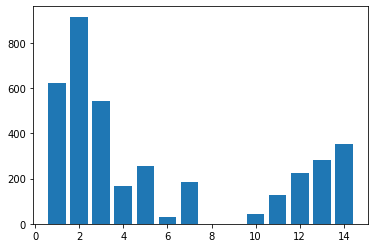

In [28]:
# heatmap of adjacency matrix
plt.clf()
plt.figure(figsize = (5,5))
plt.imshow(roleAdjacency, cmap='hot', interpolation="antialiased")
dividers = [len(teams["townsfolk"]), len(teams["townsfolk"])+len(teams["outsider"]), len(teams["townsfolk"])+len(teams["outsider"])+len(teams["minion"])]
for v in dividers:
    plt.axvline(x=v,color='green')
    plt.axhline(y=v,color='green')
plt.gca().invert_yaxis()
plt.show()

file_name = 'heatmap.xlsx'
ws = wb.worksheets[0]
ws.title = 'heatmap'
for row, rowVals in enumerate(roleAdjacency):
    for col, item in enumerate(rowVals):
        ws.cell(column=col+2, row=row+2, value=item)
        r = 255 * item / np.max(roleAdjacency)
        hexColour = '%02x%02x%02x' % (255, 255-int(r), 255-int(r))
        ws.cell(column=col+2, row=row+2).fill = openpyxl.styles.PatternFill(start_color=hexColour, end_color=hexColour, fill_type = "solid")
for i,role in enumerate(roles):
    ws.cell(column=1, row=i+2, value=role)
    ws.cell(column=i+2, row=1, value=role)
wb.save(file_name)

# SAO distribution
plt.clf()
plt.bar(amyDist.keys(), amyDist.values())
plt.show()

In [9]:
# jinxes
jinxes = []
with open("hatred.json") as j:
    jsonHatred = json.load(j)
    for jinx in jsonHatred:
        char1 = SanitizeName(jinx["id"])
        for hatred in jinx["hatred"]:
            char2 = SanitizeName(hatred["id"])
            jinxes.append((char1, char2))   

In [10]:
class InputData:
    def __init__(self, teams, teamSizes, roles, roleAdjacency, rolesInv, roleSAOs, roleTeams, amyDist, jinxes, hardRestrictions):
        self.teams = teams # teamName -> teamList
        self.teamSizes = teamSizes # teamName -> teamSize
        self.roles = roles # idx -> role
        self.roleAdjacency = roleAdjacency # [roleIdx1][roleIdx2] -> weight
        self.rolesInv = rolesInv # role -> idx
        self.roleSAOs = roleSAOs # role -> SAOclass
        self.roleTeams = roleTeams # role -> team
        self.amyDist = amyDist # SAOclass -> weight   
        self.jinxes = jinxes # idx -> (role1, role2)
        self.hardRestrictions = hardRestrictions # role1 -> requires role2
        
inputData = InputData(teams, teamSizes, roles, roleAdjacency, rolesInv, roleSAOs, roleTeams, amyDist, jinxes, hardRestrictions)

In [11]:
def WeightedSampleFromDict(d):
    k = np.array(list(d.keys()))
    p = np.array(list(d.values())) / np.sum(list(d.values()))
    return np.random.choice(k, p=p)

def SAOsort(roleList):
    roleList = sorted(roleList)
    roleList = sorted(roleList, key=lambda x: roleSAOs[x])
    roleList = sorted(roleList, key=lambda x: roleTeams[x], reverse=True)
    return roleList
    
class Script:
    def __init__(self, inputData, steps=1000, seed=0, alpha=0, beta=1):
        self.data = inputData
        self.seed = seed
        np.random.seed(seed)
        self.nSteps = 0
        self.alpha = alpha # pref attach init weight
        self.beta = beta # pref attach power
        
        self.script = {}
        for team,n in self.data.teamSizes.items():
            self.script[team] = np.random.choice(self.data.teams[team], n, replace=False)

        self.Steps(steps)
            
    def ListRoles(self):
        return [role for team in self.script for role in self.script[team]]
    
    def Step(self):
        # Gibbs sampler step
        self.nSteps += 1
        
        # choose which role to resample
        team = WeightedSampleFromDict(self.data.teamSizes)
        i = np.random.randint(0,len(self.script[team]))
        self.script[team][i] = ""
        
        # set role weights according to (sum of) adjacency to current roles
        sao = WeightedSampleFromDict(self.data.amyDist) # and filter by SAO dist if townsfolk
        scriptRoles = self.ListRoles()
        roleWeights = {}
        for role1 in scriptRoles:
            if not role1:
                continue
            for role2 in self.data.roles:
                if roleTeams[role2] != team:
                    continue
                if team == "townsfolk" and self.data.roleSAOs[role2] != sao:
                    continue
                if role2 in scriptRoles:
                    continue
                if role2 not in roleWeights:
                    roleWeights[role2] = self.alpha * np.max(self.data.roleAdjacency)
                roleWeights[role2] += self.data.roleAdjacency[self.data.rolesInv[role1],self.data.rolesInv[role2]] ** self.beta
        
        # resample
        if np.sum(list(roleWeights.values())) > 0:
            newRole = WeightedSampleFromDict(roleWeights)
        else:
            newRole = np.random.choice(self.data.teams[team])
        self.script[team][i] = newRole        
                
    def Steps(self, n):
        while (self.IsTheScriptActuallyBroken() or self.nSteps < n):
            self.Step()
        
    def IsTheScriptActuallyBroken(self):
        scriptRoles = self.ListRoles()
        for k,v in self.data.hardRestrictions.items():
            if k in scriptRoles and v not in scriptRoles:
                return True
        return False
    
    def __repr__(self):
        s = "script: " + self.ID() + "\n"
        s += "jinxes: %d" % self.CountJinxes()
        s += "\n***********\n"
        for _,teamRoles in self.script.items():
            teamRoles = SAOsort(teamRoles)
            s += ' \n'.join(teamRoles)
            s += '\n***********\n'
        return s
    
    def ID(self):
        return "%d_%d_%d_%d" % (self.nSteps, self.seed, self.alpha, self.beta)
    
    def CountJinxes(self):
        nJinxes = 0
        scriptRoles = self.ListRoles()
        for (role1,role2) in self.data.jinxes:
            if role1 in scriptRoles and role2 in scriptRoles:
                nJinxes += 1
        return nJinxes
    
    def Save(self):
        # save in json format compatible with clocktower.online
        j = []
        roles = SAOsort(self.ListRoles())
        for role in roles:
            j.append({"id":role})
        with open("script_"+self.ID()+'.json', 'w') as f:
            json.dump(j, f)
               

In [12]:
# generate a script
steps = np.random.randint(10**3,10**4)
seed = np.random.randint(10**3,10**4)
alpha = 0
beta = 1

script = Script(inputData, steps=steps, seed=seed, alpha=alpha, beta=beta)
print(script)
script.Save()

script: 3517_6605_0_1
jinxes: 3
***********
pixie 
dreamer 
fortune_teller 
sailor 
snake_charmer 
flowergirl 
innkeeper 
monk 
town_crier 
philosopher 
fisherman 
tea_lady 
cannibal
***********
drunk 
recluse 
heretic 
snitch
***********
godfather 
mastermind 
scarlet_woman 
baron
***********
fang_gu 
legion 
lleech 
no_dashii
***********

